In [239]:
from tasks import load_data_, load_, build_capsule_
import numpy as np
import theano.tensor as T
from lasagne import layers as L
import theano

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
filename = "model_E.pkl"
dataset = "digits"
data, w, h, c, nbl, nbc = load_data_(dataset=dataset)
layers = load_(filename, w=w,h=h)
capsule = build_capsule_(layers, data, nbl, nbc)

(None, 1, 28, 28)


In [37]:
print(layers.keys())

['input', 'conv1', 'conv2', 'conv3', 'wta_spatial', 'wta_channel', 'unconv', 'output']


In [78]:
from lasagnekit.misc.operations import gram_matrix
name = "wta_spatial"

print(layers[name].output_shape)
Fx, Fy = np.indices(layers[name].output_shape[2:])
Fx = Fx.astype(np.float32)
Fy = Fy.astype(np.float32)

xgen = T.tensor4()
x = T.tensor4()

ygen = L.get_output(layers[name], xgen)
y = L.get_output(layers[name], x)

def euc_presv(a, b):
    return ((a - b) ** 2).sum()

def gram(a, b):
    return ((gram_matrix(a) - gram_matrix(b))**2).mean()

def distance_presv(a, b):
    #a_ = T.eq(a, a.max(axis=(2, 3), keepdims=True))
    a_ = a
    xa = (a_ * Fx).mean()
    ya = (a_ * Fy).mean()

    #b_ = T.eq(b, b.max(axis=(2, 3), keepdims=True))
    b_ = b
    xb = (b_ * Fx).mean()
    yb = (b_ * Fy).mean()
    return ((xa-xb)**2 + (ya-yb)**2).mean()
    
F = distance_presv
loss = F(ygen, y)

grads = theano.function([x, xgen], T.grad(loss, xgen))
get_loss = theano.function([x, xgen], loss)

X = data.X
X = X.reshape((X.shape[0], c, w, h))
X = X[0:1]

(None, 128, 16, 16)


In [79]:
X_gen = np.random.uniform(size=X.shape)
X_gen = X_gen.astype(np.float32)
for i in range(10000):
    g = grads(X, X_gen)
    X_gen -= 0.001 * g
    if i % 10 == 0:
        print(get_loss(X, X_gen))

0.0301887392998
0.0301884524524
0.0301881656051
0.0301878787577
0.0301875919104
0.030187305063
0.0301870182157
0.0301867313683
0.030186444521
0.0301861595362
0.0301858726889
0.0301855858415
0.0301852989942
0.0301850121468
0.0301847252995
0.0301844384521
0.0301841516048
0.0301838666201
0.0301835816354
0.0301832985133
0.0301830135286
0.0301827285439
0.0301824435592
0.0301821604371
0.0301818754524
0.0301815904677
0.030181305483
0.0301810223609
0.0301807373762
0.0301804523915
0.0301801674068


KeyboardInterrupt: 

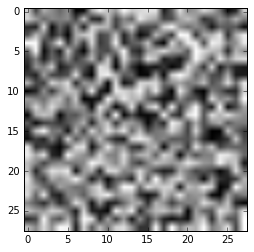

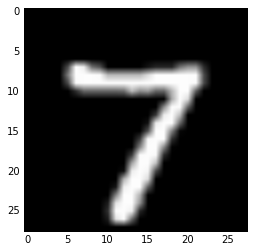

In [80]:
plt.imshow(X_gen[0, 0], cmap="gray")
plt.show()
plt.imshow(X[0, 0], cmap="gray")
plt.show()

70
70
70
70
70
70
70
70
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
5

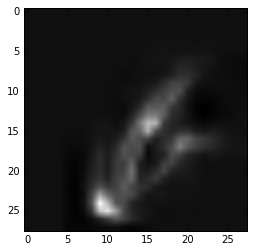

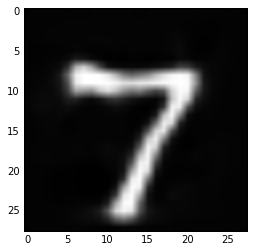

In [343]:
from itertools import combinations
name = "wta_spatial"
x = T.tensor4()
y = L.get_output(layers["output"], {layers[name]: x})

layer = L.get_output(layers[name], x)

forward = theano.function([x], y)
get_layer = theano.function([x], layer)

nbfilters, w, h = layers[name].output_shape[1:]

def rec(a):
    f = np.zeros((len(a), nbfilters, w, h))
    for i in range(len(a)):
        for k, (x, y, b) in enumerate(a[i]):
            if b>0:
                f[i, k, x, y] = 1
    f = f.astype(np.float32)
    return forward(f)[:, 0]
    
def presv(a, b):
    s = 0
    for i, j in combinations(range(len(a)), 2):
        xai, yai, ai = a[i]
        xaj, yaj, aj = a[j]
        
        xbi, ybi, bi = b[i]
        xbj, ybj, bj = b[j]
        
        da = (xai - xaj)**2 + (yai - yaj)**2
        db = (xbi - xbj)**2 + (ybi - ybj)**2
        s += (da - db) ** 2
     
    return s

def euc(a, b):
    s = 0
    for ai, bi in zip(a, b):
        for ela, elb in zip(ai, bi):
            s += abs(ela - elb)
    return s

def gen_pop(nb=10):
    d = []
    for i in range(nb):
        d_i = []
        for f in range(10):
            x, y, b = np.random.randint(0, w), np.random.randint(0, h), np.random.randint(0, 2)
            d_i.append((x, y, b))
        d.append(d_i)
    return d

def from_layer(x):
    d = []
    for f in range(x.shape[0]):
        if x[f].max()>0:
            b=1
        else:
            b=0
        fx, fy = np.unravel_index(x[f].argmax(), x[f].shape)
        d.append((fx, fy, b))
    return d

def loss(pop, desired):
    l = []
    for a in pop:
        r = euc(a, desired)
        l.append(r)
    return l
        
desired = from_layer(a[0])
pop = gen_pop(1000)
for i in range(3000):
    
    sons = []
    for p in pop:
        s = []
        for i in range(len(p)):
            if np.random.uniform() <= 0.7:
                b = 1 - p[i][2]
            else:
                b = p[i][2]
            
            if b == 0:
                x = 0
                y = 0
            else:
                x = p[i][0] + np.random.randint(-1, 1)
                y = p[i][1] + np.random.randint(-1, 1)
            x = max(min(x, w - 1), 0)
            y = max(min(y, h - 1), 0)            
            s.append((x, y, b))
        sons.append(s)
    new_pop = pop + sons
    e = loss(new_pop, desired)    
    indices = sorted(range(len(new_pop)), key=lambda i:e[i])
    pop = [new_pop[i] for i in indices[0:1000]]
    print(min(e))
    
#list(combinations([1, 2, 3], 2))
e = loss(pop[0:1], desired)

for i in range(1):
    plt.imshow(rec(pop[i:i+1])[0], cmap="gray")
    plt.show()

plt.imshow(rec([desired])[0], cmap="gray")

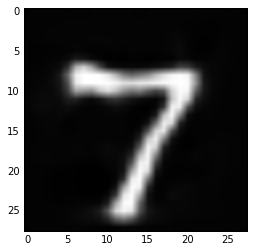

In [307]:
#l = (get_layer(X[0:1])>0)*1
l = (get_layer(X[0:1])>0)*1
#print(l.sum(axis=(2, 3)))
#print(l.max(axis=(2, 3)))
#print(l.sum(), nbfilters)
plt.imshow(forward(l)[0, 0], cmap="gray")